# Homework 2: Logistic Regression with L2 regularization

**Please type your name and A number here:**

In [2]:
Name = "Kevin Roberts"
assert Name != "", 'Please enter your name in the above quotation marks, thanks!'


A_number = "A02256264"
assert A_number != "", 'Please enter your A-number in the above quotation marks, thanks!'

The goal of this second notebook is to implement your own logistic regression classifier with L2 regularization. You will do the following:

 * Extract features from Amazon product reviews.
 * Convert a DataFrame into a NumPy array.
 * Write a function to compute the derivative of log likelihood function with an L2 penalty with respect to a single coefficient.
 * Implement gradient descent with an L2 penalty.
 * Empirically explore how the L2 penalty can ameliorate overfitting.


## Load and process review dataset

For this assignment, we will use a subset of the Amazon product review dataset. The subset was chosen to contain similar numbers of positive and negative reviews, as the original dataset consisted of mostly positive reviews.

In [7]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
products = pd.read_csv('amazon_baby_subset.csv')
products = products.fillna({'review':''})  # fill in N/A's in the review column

We will work with a hand-curated list of important words extracted from the review data. We will also perform 2 simple data transformations:

1. Remove punctuation using [Python's built-in string](https://docs.python.org/3/library/string.html) functionality.
2. Compute word counts (only for the **important_words**)

In [10]:
import json
with open('important_words.json', 'r') as f: # Reads the list of most frequent words
    important_words = json.load(f)
important_words = [str(s) for s in important_words]

def remove_punctuation(text):
    import string
    return text.translate(str.maketrans('', '', string.punctuation))

# Remove punctuation.
products['review_clean'] = products['review'].apply(remove_punctuation)

# Split out the words into individual columns
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

Now, let us take a look at what the dataset looks like (**Note:** This may take a few minutes).

In [12]:
products

,name,review,rating,sentiment,review_clean,baby,one,great,love,use,...,seems,picture,completely,wish,buying,babies,won,tub,almost,either
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,All of my kids have cried nonstop when I tried...,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1,We wanted to get something to keep track of ou...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1,My daughter had her 1st baby over a year ago S...,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1,One of babys first and favorite books and it i...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1,Very cute interactive book My son loves this b...,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53067,"Samsung Baby Care Washer, Stainless Platinum, ...","My infant goes to a really crappy daycare, and...",1,-1,My infant goes to a really crappy daycare and ...,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53068,"Mud Pie Milestone Stickers, Boy",Pretty please open and inspect these stickers ...,1,-1,Pretty please open and inspect these stickers ...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53069,Best BIB for Baby - Soft Bib (Pink-Elephant),Great 5-Star Product but An Obvious knock-off ...,1,-1,Great 5Star Product but An Obvious knockoff of...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53070,Bouncy&reg; Inflatable Real Feel Hopping Cow,When I received the item my initial thought wa...,2,-1,When I received the item my initial thought wa...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Train-Validation split

We split the data into a train-validation split with 80% of the data in the training set and 20% of the data in the validation set. We use the `seed 42` so that everyone gets the same result.

In [16]:
products_shuffled = products.sample(frac=1, ignore_index=True, random_state=42)
train_index = int(0.8*len(products_shuffled))
train_data = products_shuffled.iloc[:train_index]
validation_data = products_shuffled.iloc[train_index:]
print('Training set   : %d data points' % len(train_data))
print('Validation set : %d data points' % len(validation_data))

Training set   : 42457 data points
Validation set : 10615 data points


## Convert DataFrame to NumPy array

We provide you with a function that extracts columns from a DataFrame and converts them into a NumPy array. Two arrays are returned: one representing features and another representing class labels.

**Note:** The feature matrix includes an additional column 'intercept' filled with 1's to take account of the intercept term.

In [20]:
import numpy as np
def get_numpy_data(df, features, label):
    df['intercept'] = 1
    features = ['intercept'] + features
    features_df = df[features]
    feature_matrix = features_df.to_numpy()
    label_sarray = df[label]
    label_array = label_sarray.to_numpy()
    return(feature_matrix, label_array)

We convert both the training and validation sets into NumPy arrays.

In [23]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment')

## Building on logistic regression with no L2 penalty assignment

Recall from lecture that the function for logistic regression can be defined as:

$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))},
$$

where the feature vector $h(\mathbf{x}_i)$ is given by the word counts of **important_words** in the review $\mathbf{x}_i$.

<font color='red'> **rubric={15 points}** </font> 

In [26]:
'''
produces probablistic estimate for P(y_i = +1 | x_i, w).
estimate ranges between 0 and 1.
'''
def predict_probability(feature_matrix, coefficients):
    # Take dot product of feature_matrix and coefficients
    w_dot_h = np.dot(feature_matrix, coefficients)

    # Compute P(y_i = +1 | x_i, w)
    predictions = 1/(1 + np.exp(-w_dot_h))

    return predictions

# Adding  L2 penalty

Let us now work on extending logistic regression with L2 regularization. As discussed in the lectures, the L2 regularization is particularly useful in preventing overfitting. In this assignment, we will explore L2 regularization in detail.

Recall from the lecture that for logistic regression without an L2 penalty, the derivative of the log likelihood function with respect to the $j$-th feature of $\mathbf{x}_i$, denoted as $h_j(\mathbf{x}_i)$, is:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(P(y_i = +1 | \mathbf{x}_i, \mathbf{w})-\mathbf{1}[y_i = +1]\right)
$$

**Adding L2 penalty to the derivative**

It takes only a small modification to add a L2 penalty. All terms indicated in **red** refer to terms that were added due to an **L2 penalty**.

* Recall from the lecture that the activation function is still the sigmoid:
$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))},
$$
* We add the L2 penalty term to the per-coefficient derivative of log likelihood:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(P(y_i = +1 | \mathbf{x}_i, \mathbf{w})-\mathbf{1}[y_i = +1]\right) \color{red}{+2\lambda w_j }
$$

The **per-coefficient derivative for logistic regression with an L2 penalty** is as follows:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(P(y_i = +1 | \mathbf{x}_i, \mathbf{w})-\mathbf{1}[y_i = +1]\right) \color{red}{+2\lambda w_j }
$$
and for the intercept term, we have
$$
\frac{\partial\ell}{\partial w_0} = \sum_{i=1}^N h_0(\mathbf{x}_i)\left(P(y_i = +1 | \mathbf{x}_i, \mathbf{w})-\mathbf{1}[y_i = +1]\right)
$$

**Note**: As we did in the Regression course, we do not apply the L2 penalty on the intercept. A large intercept does not necessarily indicate overfitting because the intercept is not associated with any particular feature.

Write a function that computes the derivative of log likelihood with respect to a single coefficient $w_j$. Unlike its counterpart in the last assignment, the function accepts five arguments:
 * `errors` vector containing $(P(y_i = +1 | \mathbf{x}_i, \mathbf{w})-\mathbf{1}[y_i = +1])$ for all $i$
 * `feature` vector containing $h_j(\mathbf{x}_i)$  for all $i$
 * `coefficient` containing the current value of coefficient $w_j$.
 * `l2_penalty` representing the L2 penalty constant $\lambda$
 * `feature_is_constant` telling whether the $j$-th feature is constant or not.

 <font color='red'> **rubric={15 points}** </font> 

In [32]:
def feature_derivative_with_L2(errors, feature, coefficient, l2_penalty, feature_is_constant):

    # Compute the dot product of errors and feature
    errors_dot_feature = np.dot(errors, feature)
    
    derivative = errors_dot_feature

    # add L2 penalty term for any feature that isn't the intercept.
    if not feature_is_constant:
        derivative = errors_dot_feature + 2*l2_penalty*coefficient

    return derivative

<font color='red'> **rubric={5 points}** </font> 

**Quiz Question:** In the code above, was the intercept term regularized?  


**Answer:** No, because of the 'if not feature_is_constant' if statement.

To verify the correctness of the gradient descent algorithm, we provide a function for computing negative log likelihood.

$$\ell\ell(\mathbf{w}) = - \sum_{i=1}^N \Big( (\mathbf{1}[y_i = +1] - 1)\mathbf{w}^T h(\mathbf{x}_i) - \ln\left(1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))\right) \Big) \color{red}{+ \lambda\|\mathbf{w}\|_2^2} $$

In [48]:
def compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty):
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)

    lp = -np.sum((indicator-1)*scores - np.log(1. + np.exp(-scores))) + l2_penalty*np.sum(coefficients[1:]**2)

    return lp

**Quiz Question:** Does the term with L2 regularization increase or decrease $\ell\ell(\mathbf{w})$?  

 <font color='red'> **rubric={5 points}** </font> 

**Answer:** The term decreases ll(w) since it adds a penalty to the negative log likelihood function.

Fill in the code below to complete the logistic regression function with L2 penalty.

<font color='red'> **rubric={30 points}** </font> 

In [53]:
def logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, l2_penalty, max_iter):
    coefficients = np.array(initial_coefficients) # make sure it's a numpy array
    for itr in range(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        ## YOUR CODE HERE
        predictions = predict_probability(feature_matrix, coefficients)

        # Compute indicator value for (y_i = +1)
        indicator = (sentiment==+1)

        # Compute the errors as predictions - indicator
        errors = predictions - indicator
        for j in range(len(coefficients)): # loop over each coefficient
            is_intercept = (j == 0)
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j].
            # Compute the derivative for coefficients[j]. Save it in a variable called derivative
            ## YOUR CODE HERE
            if is_intercept:
                derivative = np.dot(feature_matrix[:,j], errors)  # No L2 penalty 
            else:
                derivative = np.dot(feature_matrix[:,j], errors) + 2*l2_penalty*coefficients[j]  # L2 regularization

            # add the step size times the derivative to the current coefficient
            ## YOUR CODE HERE
            coefficients[j] -= step_size * derivative

        # Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty)
            print('iteration %*d: log likelihood of observed labels = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, lp))
    return coefficients

# Explore effects of L2 regularization

Now that we have written up all the pieces needed for regularized logistic regression, let's explore the benefits of using **L2 regularization** in analyzing sentiment for product reviews. **As iterations pass, the log likelihood should increase**.

Below, we train models with increasing amounts of regularization, starting with no L2 penalty, which is equivalent to our previous logistic regression implementation.

In [56]:
# run with L2 = 0
coefficients_0_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                     initial_coefficients=np.zeros(194),
                                                     step_size=5e-6, l2_penalty=0, max_iter=501)

iteration   0: log likelihood of observed labels = 29246.01157659
iteration   1: log likelihood of observed labels = 29070.58360222
iteration   2: log likelihood of observed labels = 28901.88872854
iteration   3: log likelihood of observed labels = 28739.35473391
iteration   4: log likelihood of observed labels = 28582.53738048
iteration   5: log likelihood of observed labels = 28431.07439712
iteration   6: log likelihood of observed labels = 28284.65788683
iteration   7: log likelihood of observed labels = 28143.01762536
iteration   8: log likelihood of observed labels = 28005.91080612
iteration   9: log likelihood of observed labels = 27873.11562229
iteration  10: log likelihood of observed labels = 27744.42714907
iteration  11: log likelihood of observed labels = 27619.65461465
iteration  12: log likelihood of observed labels = 27498.61951642
iteration  13: log likelihood of observed labels = 27381.15425730
iteration  14: log likelihood of observed labels = 27267.10110720
iteration 

In [58]:
# run with L2 = 4
coefficients_4_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                      initial_coefficients=np.zeros(194),
                                                      step_size=5e-6, l2_penalty=4, max_iter=501)

iteration   0: log likelihood of observed labels = 29246.01527521
iteration   1: log likelihood of observed labels = 29070.60517052
iteration   2: log likelihood of observed labels = 28901.94121951
iteration   3: log likelihood of observed labels = 28739.45023721
iteration   4: log likelihood of observed labels = 28582.68712921
iteration   5: log likelihood of observed labels = 28431.28884792
iteration   6: log likelihood of observed labels = 28284.94678468
iteration   7: log likelihood of observed labels = 28143.39005893
iteration   8: log likelihood of observed labels = 28006.37525691
iteration   9: log likelihood of observed labels = 27873.68000912
iteration  10: log likelihood of observed labels = 27745.09886889
iteration  11: log likelihood of observed labels = 27620.44058010
iteration  12: log likelihood of observed labels = 27499.52619047
iteration  13: log likelihood of observed labels = 27382.18768525
iteration  14: log likelihood of observed labels = 27268.26694618
iteration 

In [60]:
# run with L2 = 10
coefficients_10_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                      initial_coefficients=np.zeros(194),
                                                      step_size=5e-6, l2_penalty=10, max_iter=501)

iteration   0: log likelihood of observed labels = 29246.02082315
iteration   1: log likelihood of observed labels = 29070.63752078
iteration   2: log likelihood of observed labels = 28902.01994537
iteration   3: log likelihood of observed labels = 28739.59346338
iteration   4: log likelihood of observed labels = 28582.91169234
iteration   5: log likelihood of observed labels = 28431.61041714
iteration   6: log likelihood of observed labels = 28285.37995903
iteration   7: log likelihood of observed labels = 28143.94845070
iteration   8: log likelihood of observed labels = 28007.07156554
iteration   9: log likelihood of observed labels = 27874.52608822
iteration  10: log likelihood of observed labels = 27746.10578757
iteration  11: log likelihood of observed labels = 27621.61867951
iteration  12: log likelihood of observed labels = 27500.88513595
iteration  13: log likelihood of observed labels = 27383.73651440
iteration  14: log likelihood of observed labels = 27270.01411327
iteration 

In [62]:
# run with L2 = 1e2
coefficients_1e2_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e2, max_iter=501)

iteration   0: log likelihood of observed labels = 29246.10404218
iteration   1: log likelihood of observed labels = 29071.12246042
iteration   2: log likelihood of observed labels = 28903.19931056
iteration   3: log likelihood of observed labels = 28741.73771763
iteration   4: log likelihood of observed labels = 28586.27152142
iteration   5: log likelihood of observed labels = 28436.41858528
iteration   6: log likelihood of observed labels = 28291.85281380
iteration   7: log likelihood of observed labels = 28152.28721153
iteration   8: log likelihood of observed labels = 28017.46346710
iteration   9: log likelihood of observed labels = 27887.14541624
iteration  10: log likelihood of observed labels = 27761.11482736
iteration  11: log likelihood of observed labels = 27639.16858868
iteration  12: log likelihood of observed labels = 27521.11674890
iteration  13: log likelihood of observed labels = 27406.78108400
iteration  14: log likelihood of observed labels = 27295.99399466
iteration 

In [64]:
# run with L2 = 1e3
coefficients_1e3_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e3, max_iter=501)

iteration   0: log likelihood of observed labels = 29246.93623254
iteration   1: log likelihood of observed labels = 29075.93952505
iteration   2: log likelihood of observed labels = 28914.83710913
iteration   3: log likelihood of observed labels = 28762.75882518
iteration   4: log likelihood of observed labels = 28618.99652798
iteration   5: log likelihood of observed labels = 28482.95041994
iteration   6: log likelihood of observed labels = 28354.09686671
iteration   7: log likelihood of observed labels = 28231.96872053
iteration   8: log likelihood of observed labels = 28116.14295371
iteration   9: log likelihood of observed labels = 28006.23260146
iteration  10: log likelihood of observed labels = 27901.88127632
iteration  11: log likelihood of observed labels = 27802.75924238
iteration  12: log likelihood of observed labels = 27708.56045637
iteration  13: log likelihood of observed labels = 27619.00022661
iteration  14: log likelihood of observed labels = 27533.81328179
iteration 

In [66]:
# run with L2 = 1e5
coefficients_1e5_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e5, max_iter=501)

iteration   0: log likelihood of observed labels = 29338.47717159
iteration   1: log likelihood of observed labels = 29338.37662809
iteration   2: log likelihood of observed labels = 29338.37226592
iteration   3: log likelihood of observed labels = 29338.37065538
iteration   4: log likelihood of observed labels = 29338.36929552
iteration   5: log likelihood of observed labels = 29338.36806856
iteration   6: log likelihood of observed labels = 29338.36695794
iteration   7: log likelihood of observed labels = 29338.36595246
iteration   8: log likelihood of observed labels = 29338.36504217
iteration   9: log likelihood of observed labels = 29338.36421805
iteration  10: log likelihood of observed labels = 29338.36347194
iteration  11: log likelihood of observed labels = 29338.36279646
iteration  12: log likelihood of observed labels = 29338.36218493
iteration  13: log likelihood of observed labels = 29338.36163129
iteration  14: log likelihood of observed labels = 29338.36113006
iteration 

## Compare coefficients

We now compare the **coefficients** for each of the models that were trained above. We will create a DataFrame of features and learned coefficients associated with each of the different L2 penalty values.

Below is a simple helper function that will help us create this DataFrame.

In [69]:
df_coef = pd.DataFrame({'word': ['(intercept)'] + important_words})
df_coef['coefficients [L2=0]'] = coefficients_0_penalty
df_coef['coefficients [L2=4]'] = coefficients_4_penalty
df_coef['coefficients [L2=10]'] = coefficients_10_penalty
df_coef['coefficients [L2=1e2]'] = coefficients_1e2_penalty
df_coef['coefficients [L2=1e3]'] = coefficients_1e3_penalty
df_coef['coefficients [L2=1e5]'] = coefficients_1e5_penalty

Using **the coefficients trained with L2 penalty 0**, find the 5 most positive words (with largest positive coefficients). Save them to **positive_words**. Similarly, find the 5 most negative words (with largest negative coefficients) and save them to **negative_words**.

<font color='red'> **rubric={15 points}** </font> 

In [72]:
## YOUR CODE HERE
# Sort the words based on the coefficients
df_sorted = df_coef.sort_values(by='coefficients [L2=0]', ascending=False)

# Select the top 5 most positive words
positive_words = df_sorted['word'].iloc[:5].tolist()

# Select the top 5 most negative words
negative_words = df_sorted['word'].iloc[-5:].tolist()

# Print results
print("Most Positive Words:", positive_words)
print("Most Negative Words:", negative_words)


Most Positive Words: ['loves', 'love', 'easy', 'perfect', 'great']
Most Negative Words: ['returned', 'waste', 'return', 'money', 'disappointed']


Let us observe the effect of increasing L2 penalty on the 10 words just selected. We provide you with a utility function to  plot the coefficient path.

In [75]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6

def make_coefficient_plot(df, positive_words, negative_words, l2_penalty_list):
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')

    xx = l2_penalty_list
    plt.plot(xx, [0.]*len(xx), '--', lw=1, color='k')

    lst_positive_words = df.loc[df['word'].isin(positive_words)].iloc[:,1:].values
    lst_negative_words = df.loc[df['word'].isin(negative_words)].iloc[:,1:].values

    for i in range(len(positive_words)):
        color = cmap_positive(0.8*((i+1)/(len(positive_words)*1.2)+0.15))
        plt.plot(xx, lst_positive_words[i:i+1].flatten(),
                 '-', label=positive_words[i], linewidth=4.0, color=color)

    for i in range(len(negative_words)):
        color = cmap_negative(0.8*((i+1)/(len(negative_words)*1.2)+0.15))
        plt.plot(xx, lst_negative_words[i:i+1].flatten(),
                 '-', label=negative_words[i], linewidth=4.0, color=color)

    plt.legend(loc='best', ncol=3, prop={'size':16}, columnspacing=0.5)
    plt.axis([1, 1e5, -1, 2])
    plt.title('Coefficient path')
    plt.xlabel('L2 penalty ($\lambda$)')
    plt.ylabel('Coefficient value')
    plt.xscale('log')
    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()

Run the following cell to generate the plot. Use the plot to answer the following quiz question.

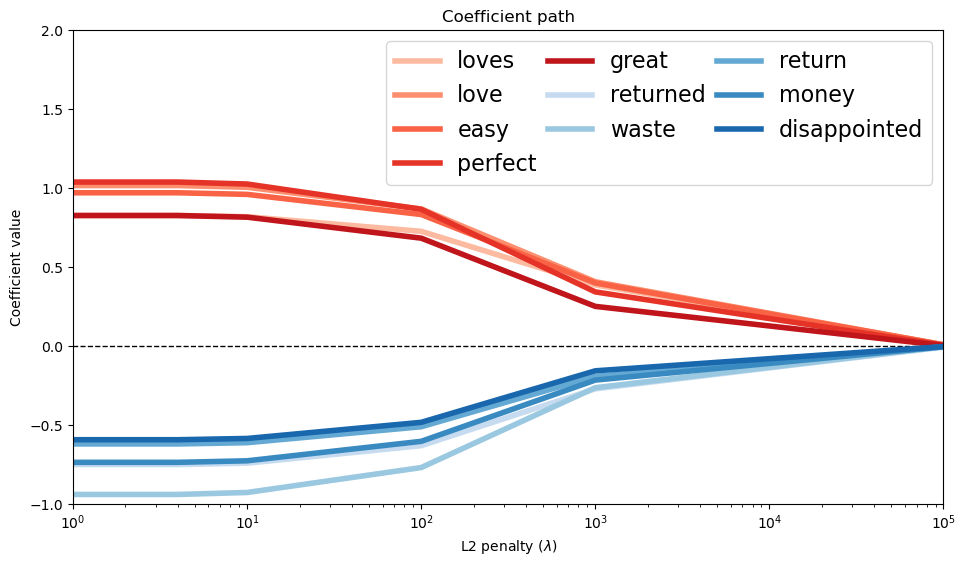

In [78]:
make_coefficient_plot(df_coef, positive_words, negative_words, l2_penalty_list=[0, 4, 10, 1e2, 1e3, 1e5])

**Quiz Question**: (True/False) All coefficients consistently get smaller in size as the L2 penalty is increased.

<font color='red'> **rubric={3 points}** </font> 

**Answer:** True.

**Quiz Question**: (True/False) The relative order of coefficients is preserved as the L2 penalty is increased. (For example, if the coefficient for 'cat' was more positive than that for 'dog', this remains true as the L2 penalty increases.)

<font color='red'> **rubric={3 points}** </font> 

**Answer:** True.

## Measuring accuracy

Now, let us compute the accuracy of the classifier model. Recall that the accuracy is given by

$$
accuracy = \frac{\text{\# correctly classified data points}}{\text{\# total data points}}
$$


Recall from lecture that that the class prediction is calculated using
$$
\hat{y}_i =
\left\{
\begin{array}{ll}
      +1 & h(\mathbf{x}_i)^T\mathbf{w} > 0 \\
      -1 & h(\mathbf{x}_i)^T\mathbf{w} \leq 0 \\
\end{array}
\right.
$$

We can implement the code to calculate the accuracy.

In [84]:
def get_classification_accuracy(feature_matrix, sentiment, coefficients):
    scores = np.dot(feature_matrix, coefficients)
    apply_threshold = np.vectorize(lambda x: 1. if x > 0  else -1.)
    predictions = apply_threshold(scores)

    num_correct = (predictions == sentiment).sum()
    accuracy = num_correct / len(feature_matrix)
    return accuracy

Below, we compare the accuracy on the **training data** and **validation data** for all the models that were trained in this assignment.  We first calculate the accuracy values and then build a simple report summarizing the performance for the various models.

In [87]:
train_accuracy = {}
train_accuracy[0]   = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_0_penalty)
train_accuracy[4]   = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_4_penalty)
train_accuracy[10]  = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_10_penalty)
train_accuracy[1e2] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e2_penalty)
train_accuracy[1e3] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e3_penalty)
train_accuracy[1e5] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e5_penalty)

validation_accuracy = {}
validation_accuracy[0]   = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_0_penalty)
validation_accuracy[4]   = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_4_penalty)
validation_accuracy[10]  = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_10_penalty)
validation_accuracy[1e2] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e2_penalty)
validation_accuracy[1e3] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e3_penalty)
validation_accuracy[1e5] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e5_penalty)

In [89]:
# Build a simple report
for key in sorted(validation_accuracy.keys()):
    print("L2 penalty = %g" % key)
    print("train accuracy = %s, validation_accuracy = %s" % (train_accuracy[key], validation_accuracy[key]))
    print("--------------------------------------------------------------------------------")

L2 penalty = 0
train accuracy = 0.783687024518925, validation_accuracy = 0.785115402731983
--------------------------------------------------------------------------------
L2 penalty = 4
train accuracy = 0.7835457050663024, validation_accuracy = 0.7850211964201601
--------------------------------------------------------------------------------
L2 penalty = 10
train accuracy = 0.783475045339991, validation_accuracy = 0.7848327837965143
--------------------------------------------------------------------------------
L2 penalty = 100
train accuracy = 0.7830510869821231, validation_accuracy = 0.7828544512482336
--------------------------------------------------------------------------------
L2 penalty = 1000
train accuracy = 0.7728760863932921, validation_accuracy = 0.7741874705605275
--------------------------------------------------------------------------------
L2 penalty = 100000
train accuracy = 0.7445179829003462, validation_accuracy = 0.7440414507772021
-----------------------------

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

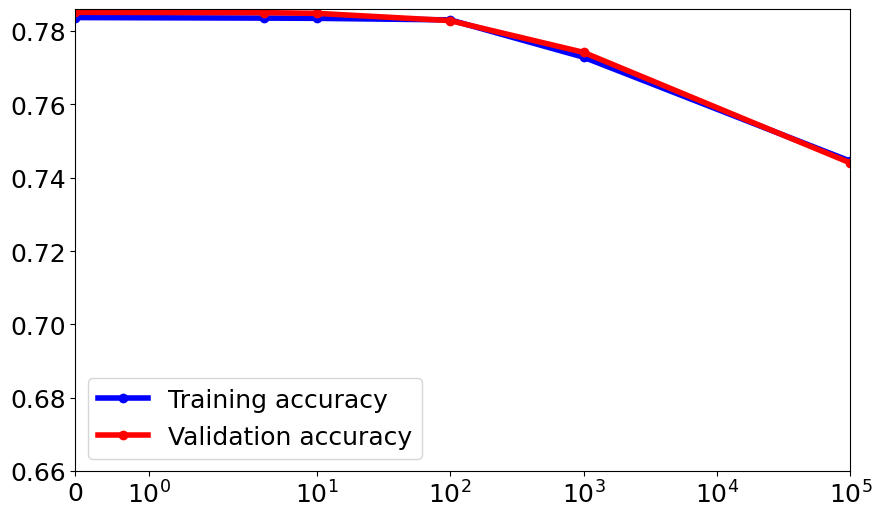

In [91]:
# Optional. Plot accuracy on training and validation sets over choice of L2 penalty.
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6

sorted_list = sorted(train_accuracy.items(), key=lambda x:x[0])
plt.plot([p[0] for p in sorted_list], [p[1] for p in sorted_list], 'bo-', linewidth=4, label='Training accuracy')
sorted_list = sorted(validation_accuracy.items(), key=lambda x:x[0])
plt.plot([p[0] for p in sorted_list], [p[1] for p in sorted_list], 'ro-', linewidth=4, label='Validation accuracy')
plt.xscale('symlog')
plt.axis([0, 1e5, 0.66, 0.786])
plt.legend(loc='lower left')
plt.rcParams.update({'font.size': 18})
plt.tight_layout

**Quiz Question**: Which model (L2 = 0, 4, 10, 100, 1e3, 1e5) has the **highest** accuracy on the **training** data?

<font color='red'> **rubric={3 points}** </font> 

**Answer:** The L2 = 0 has the highest accuracy on the training data.

**Quiz Question**: Which model (L2 = 0, 4, 10, 100, 1e3, 1e5) has the **highest** accuracy on the **validation** data?

<font color='red'> **rubric={3 points}** </font> 

**Answer:** The L2 = 0 also has the highest accuracy on the validation data.

**Quiz Question**: Does the **highest** accuracy on the **training** data imply that the model is the best one?

<font color='red'> **rubric={3 points}** </font> 

**Answer:** Not necessarily. High accuracy on the training data does not imply high accuracy on the test data, so even if the model has high training accuracy, it may not be the best one.